In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load data and apply normlization

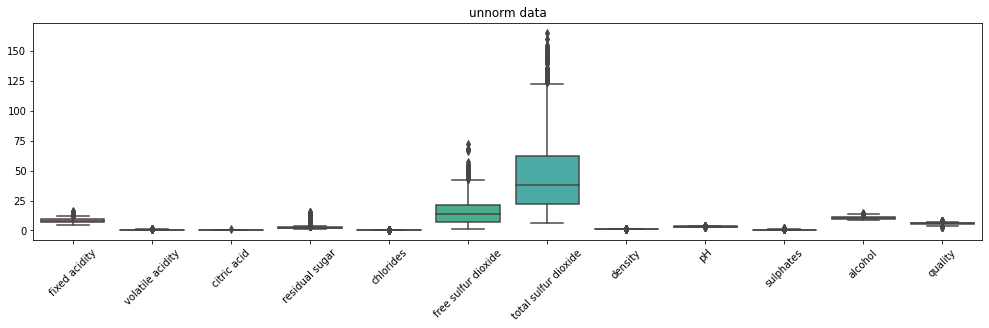

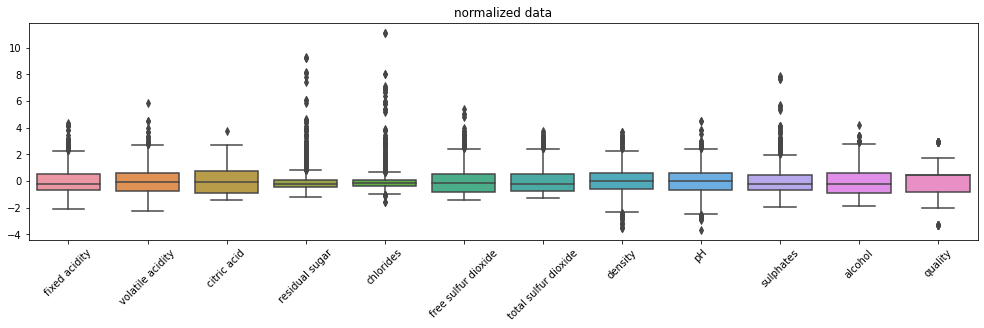

In [143]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
data=data[data['total sulfur dioxide']<200]
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('unnorm data')
#zscore normilziation
cols2zscore=data.keys()
data[cols2zscore]=data[cols2zscore].apply(stats.zscore)

fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('normalized data')
plt.show()

data split two parts: data and test

In [144]:
cols2zscore=cols2zscore.drop('residual sugar')
dataTrain=torch.tensor(data[cols2zscore].values).float()
sugar=torch.tensor(data['residual sugar'].values).float()
sugar=sugar[:,None]

train_data,test_data,train_label,test_label=train_test_split(dataTrain,sugar,test_size=.1)

train_dataSet=TensorDataset(train_data,train_label)
test_dataSet=TensorDataset(test_data,test_label)

train_loader=DataLoader(train_dataSet,batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(test_dataSet,batch_size=test_dataSet.tensors[0].shape[0])
# for dat,lab in train_loader:print(dat,shape)

nueral network

In [165]:
class ANN_sugar(nn.Module):
    def __init__(self,dropRate):
        super().__init__()
        #input
        self.input=nn.Linear(11,64)

        #hidden layer
        self.fc1=nn.Linear(64,128)
        self.fc2=nn.Linear(128,256)
        self.fc3=nn.Linear(256,128)

        #output
        self.output=nn.Linear(128,1)

        self.dr=dropRate
    def forward(self,x):
        x=F.relu(self.input(x))
        x=F.dropout(x,p=self.dr,training=self.training)

        x=F.relu(self.fc1(x))
        x=F.dropout(x,p=self.dr,training=self.training)

        x=F.relu(self.fc2(x))
        x=F.dropout(x,p=self.dr,training=self.training)

        x=F.relu(self.fc3(x))
        x=F.dropout(x,p=self.dr,training=self.training)
        x=self.output(x)
        return x

In [174]:
def createANN(droprate):
    ANN=ANN_sugar(droprate)
    #loss function:Mean Squeared Error 
    lossfun=nn.MSELoss()
    
    #optimizer function: stochastic gradient descent
    optimizer=torch.optim.SGD(ANN.parameters(),lr=.001)
    
    return ANN,lossfun,optimizer

In [177]:
def trainModel(data_load=None,test_load=None,ANN_model=None,loss_func=None,\
               Optimizer=None,Numepoch=1000):
    # trainAcc=[] #accuracy of train data set over each epoch
    # testAcc=[]#accuracy of test data set over each epoch
    losses=torch.zeros(Numepoch) # contain loss values
    test_losses=torch.zeros(Numepoch)
    for epoch in range(Numepoch):
        ANN_model.train()

        batchacc=[]
        batchloss=[]

        for dat,lab in data_load:
            yHat=ANN_model(dat)
            loss=loss_func(yHat,lab)

            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()

            batchloss.append(loss.item())
            # batchacc.append(100*torch.mean())
        losses[epoch]=np.mean(batchloss)

        ANN_model.eval()
        dat,lab=next(iter(test_load))
        with torch.no_grad():
            yHat=ANN_model(dat)
        
        test_losses[epoch]=loss_func(yHat,lab).item()
    return losses,test_losses

In [178]:
ANN,lossfun,optimizer=createANN(0.)
losses,test_losses=trainModel(train_loader,test_loader,ANN,lossfun,optimizer)

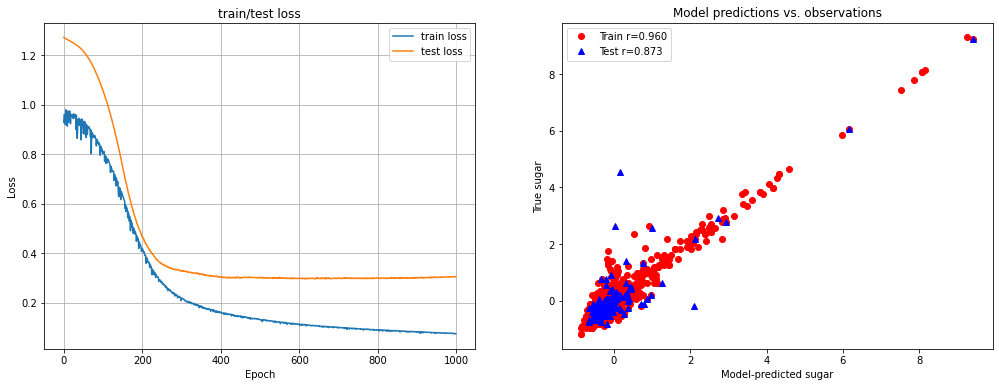

In [179]:
fig,axs=plt.subplots(1,2,figsize=(17,6))
axs[0].plot(losses,label='train loss')
axs[0].plot(test_losses,label='test loss')
axs[0].set_title('train/test loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

yHatTrain=ANN(train_data)
yHatest=ANN(test_data)
axs[1].plot(yHatTrain.detach(),train_label,'ro')
axs[1].plot(yHatest.detach(),test_label,'b^')
axs[1].set_xlabel('Model-predicted sugar')
axs[1].set_ylabel('True sugar')
axs[1].set_title('Model predictions vs. observations')

corrTrain = np.corrcoef(yHatTrain.detach().T,train_label.T)[1,0]
corrTest  = np.corrcoef(yHatest.detach().T, test_label.T)[1,0]
axs[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()